In [37]:
import numpy as np
import pandas as pd
from fastai.vision.all import *
from fastai.vision.widgets import *

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
# urls = search_images('spring in london park', max_images=1)
# urls[0]

Searching for 'spring in london park'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://media.timeout.com/images/102522251/image.jpg'

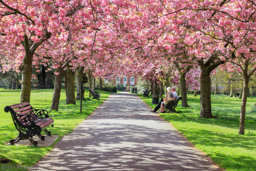

In [6]:
# from fastdownload import download_url
# dest = 'spring.jpg'
# download_url(urls[0], dest, show_progress=False)

# from fastai.vision.all import *
# im = Image.open(dest)
# im.to_thumb(256,256)

In [12]:
season_types = 'spring', 'summer', 'autumn', 'winter'
path = Path('seasons')  

from time import sleep

for o in season_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} in a city park'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} in a north'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in a south'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'spring in a city park'
Searching for 'spring in a north'
Searching for 'spring in a south'
Searching for 'summer in a city park'
Searching for 'summer in a north'
Searching for 'summer in a south'
Searching for 'autumn in a city park'
Searching for 'autumn in a north'
Searching for 'autumn in a south'
Searching for 'winter in a city park'
Searching for 'winter in a north'
Searching for 'winter in a south'


In [13]:
fns = get_image_files(path)

failed = verify_images(fns)
failed

(#26) [Path('seasons/spring/27bf9b27-4903-41ad-813b-1971d5c3b04c.jpg'),Path('seasons/spring/aed923a1-5272-4be4-b7bf-98eb3635967a.jpg'),Path('seasons/spring/c730b849-e796-4ad8-bfdf-3b97effd818d.jpg'),Path('seasons/spring/7aada293-d68d-4c26-ad15-01af1e94465e.jpg'),Path('seasons/spring/50f121a4-8423-4563-baf7-72ada02545e6.jpg'),Path('seasons/spring/c10e29dd-d268-44d8-8011-484302fb8f7a.jpg'),Path('seasons/summer/8afc2e70-35a8-46d1-929d-4dfc7ef86ed9.jpg'),Path('seasons/summer/26507b41-c95d-4be1-b615-43b12bb33190.jpg'),Path('seasons/summer/270d7771-4d72-4aca-9d1c-49cfd7148e33.jpg'),Path('seasons/summer/83c5d7a3-8aff-4132-894f-5de961c057a8.jpg')...]

In [14]:
failed.map(Path.unlink);

In [19]:
seasons = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = seasons.dataloaders(path)

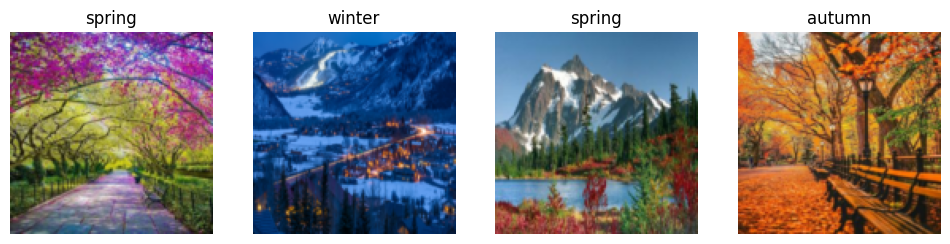

In [25]:
dls.valid.show_batch(max_n=4, nrows=1)

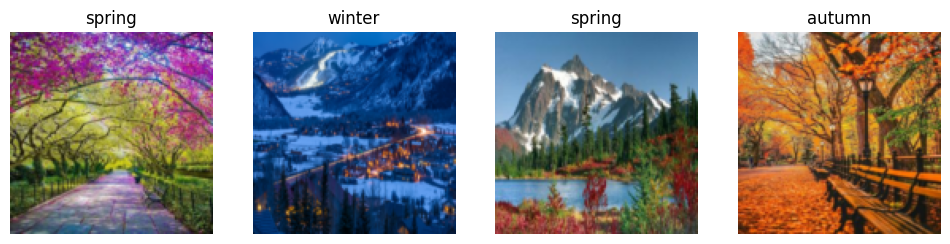

In [22]:
seasons = seasons.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = seasons.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

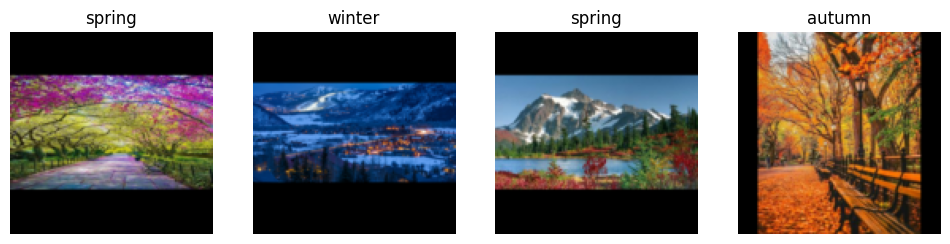

In [26]:
seasons = seasons.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = seasons.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

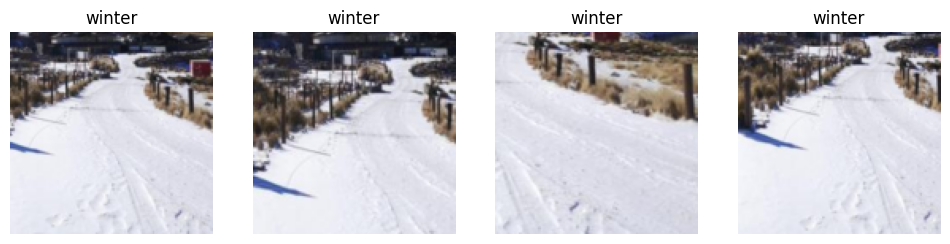

In [27]:
seasons = seasons.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = seasons.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

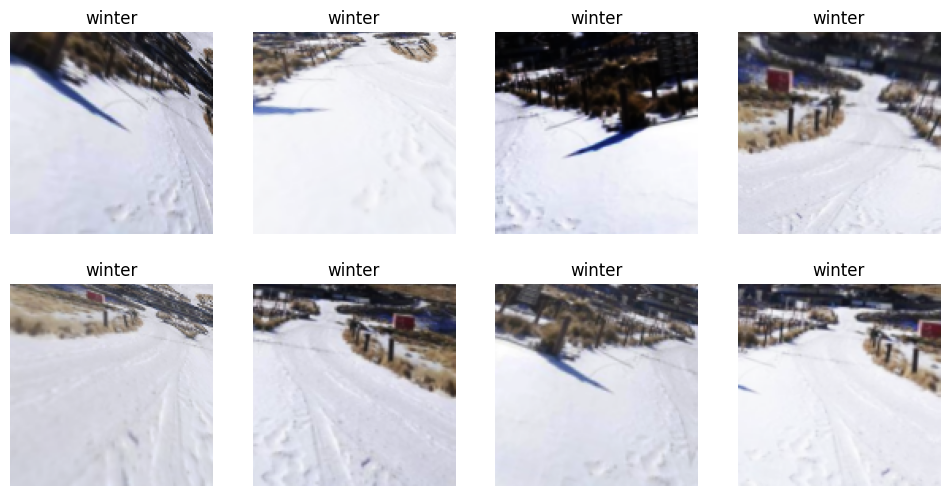

In [29]:
seasons = seasons.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = seasons.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [30]:
seasons = seasons.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = seasons.dataloaders(path)

In [33]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.214658,1.342293,0.514286,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.241333,0.839946,0.352381,00:02
1,1.082040,0.562252,0.238095,00:02
2,0.926282,0.446024,0.152381,00:02
3,0.796975,0.447455,0.152381,00:02
4,0.672134,0.416460,0.152381,00:02
5,0.599814,0.407040,0.152381,00:02


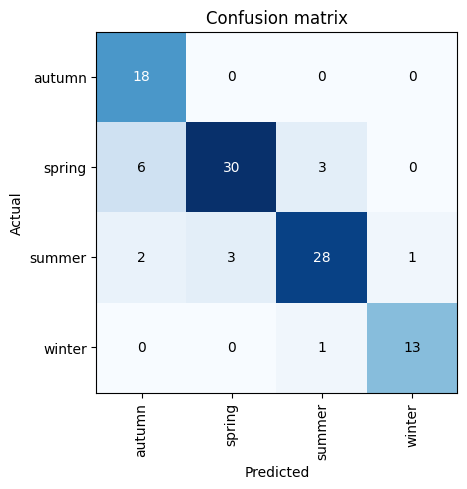

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

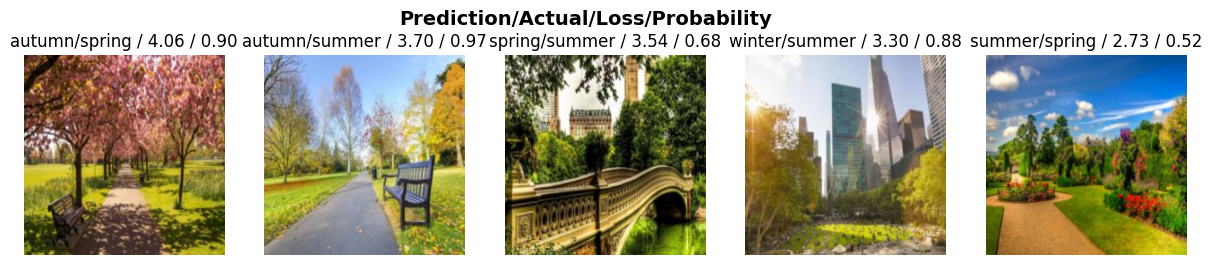

In [35]:
interp.plot_top_losses(5, nrows=1)

In [38]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [39]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [40]:
# season,_,probs = learn.predict(PILImage.create('spring.jpg'))
# print(f"This is a: {season}.")

This is a: spring.


In [44]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#0) []

In [45]:
learn_inf = load_learner(path/'export.pkl')

In [46]:
learn_inf.predict('spring.jpg')

('spring', tensor(1), tensor([2.1659e-02, 9.4474e-01, 5.4822e-04, 3.3051e-02]))

In [47]:
learn_inf.dls.vocab

['autumn', 'spring', 'summer', 'winter']